In [1]:
print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

Automatically created module for IPython interactive environment


In [5]:
#from mangaki.utils.data import Dataset
from mangaki.algo.fit_algo import get_dataset_backup
from mangaki.algo.dataset import Dataset

dataset = Dataset()
dataset.load('tsne.pickle')

In [6]:
dataset.anonymized

AnonymizedData(X=array([[1444,  262],
       [1780,  408],
       [1187, 1014],
       ..., 
       [ 337,  448],
       [1386,  452],
       [1473,  361]]), y=array([-2. ,  2. ,  2. , ...,  2. ,  0.5,  0.5]), y_text=array(['dislike', 'like', 'like', ..., 'like', 'willsee', 'willsee'],
      dtype='<U8'), nb_users=2112, nb_works=10031)

In [9]:
from mangaki.algo.als import MangakiALS

als = MangakiALS(30)

In [10]:
als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
als.fit(dataset.anonymized.X, dataset.anonymized.y)

Computing M: (2112 × 10031)
Chrono: fill and center matrix [0q, 10311ms]
Shapes (2112, 30) (30, 10031)
Chrono: factor matrix [0q, 9407ms]


In [12]:
als.save(als.get_backup_filename())

In [55]:
NB_USERS = 250
NB_WORKS = 250

In [48]:
#M = X.toarray().T
#from mangaki.algo.fit_algo import get_algo_backup
#svd = get_algo_backup('svd')
M = np.vstack((als.VT.T[:250, :], als.U[:250, :]))

In [49]:
M.shape

(500, 30)

In [50]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(M)
print(time() - t0, 'seconds')

9.50310206413269 seconds


In [51]:
X_tsne.shape

(500, 2)

In [52]:
print(X_tsne.min(axis=0))
print(X_tsne.max(axis=0))

[-32.93112564 -25.72217941]
[ 34.20620346  24.68154144]


In [56]:
users = User.objects.in_bulk([dataset.decode_user[i] for i in range(NB_USERS)])
items = Work.objects.in_bulk([dataset.decode_work[i] for i in range(NB_WORKS)])

In [57]:
user_points = []
work_points = []
for i, (x, y) in enumerate(X_tsne.astype(np.float64)):
    if i < NB_WORKS:
        work_points.append({'title': items[dataset.decode_work[i]].title, 'x': x, 'y': y})
    else:
        user_points.append({'title': users[dataset.decode_user[i - NB_WORKS]].username, 'x': x, 'y': y})

In [58]:
import json

with open('/Users/jilljenn/Desktop/points.json', 'w') as f:
    f.write(json.dumps({'works': work_points, 'users': user_points}))

In [59]:
X_2d = X_tsne

In [60]:
import matplotlib.pyplot as plt
plt.scatter(X_2d[:, 0], X_2d[:, 1])

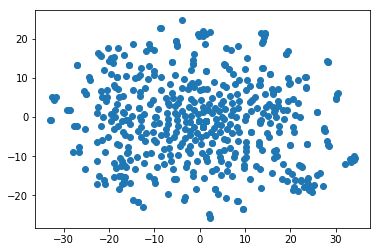

In [61]:
plt.show()

In [25]:
from mangaki.models import Work
titles = dict(Work.objects.values_list('id', 'title'))

In [26]:
encoded_dn = dataset.encode_work[1]

In [27]:
from scipy.spatial.distance import pdist, squareform
lol = squareform(pdist(X_2d, 'euclidean'))

In [28]:
lol.shape

(1000, 1000)

In [29]:
def get_closest(work_id, nb_neighbors=5):
    encoded_work = dataset.encode_work[work_id]
    closest = np.argsort(lol[encoded_work])[:nb_neighbors]
    for encoded_work_id in closest:
        print(titles[dataset.decode_work[encoded_work_id]])

In [39]:
'''with open('tsne.npy', 'wb') as f:
    np.save(f, X_2d)'''

In [40]:
'''with open('tsne.npy', 'rb') as f:
    bla = np.load(f)'''

<IPython.core.display.Javascript object>


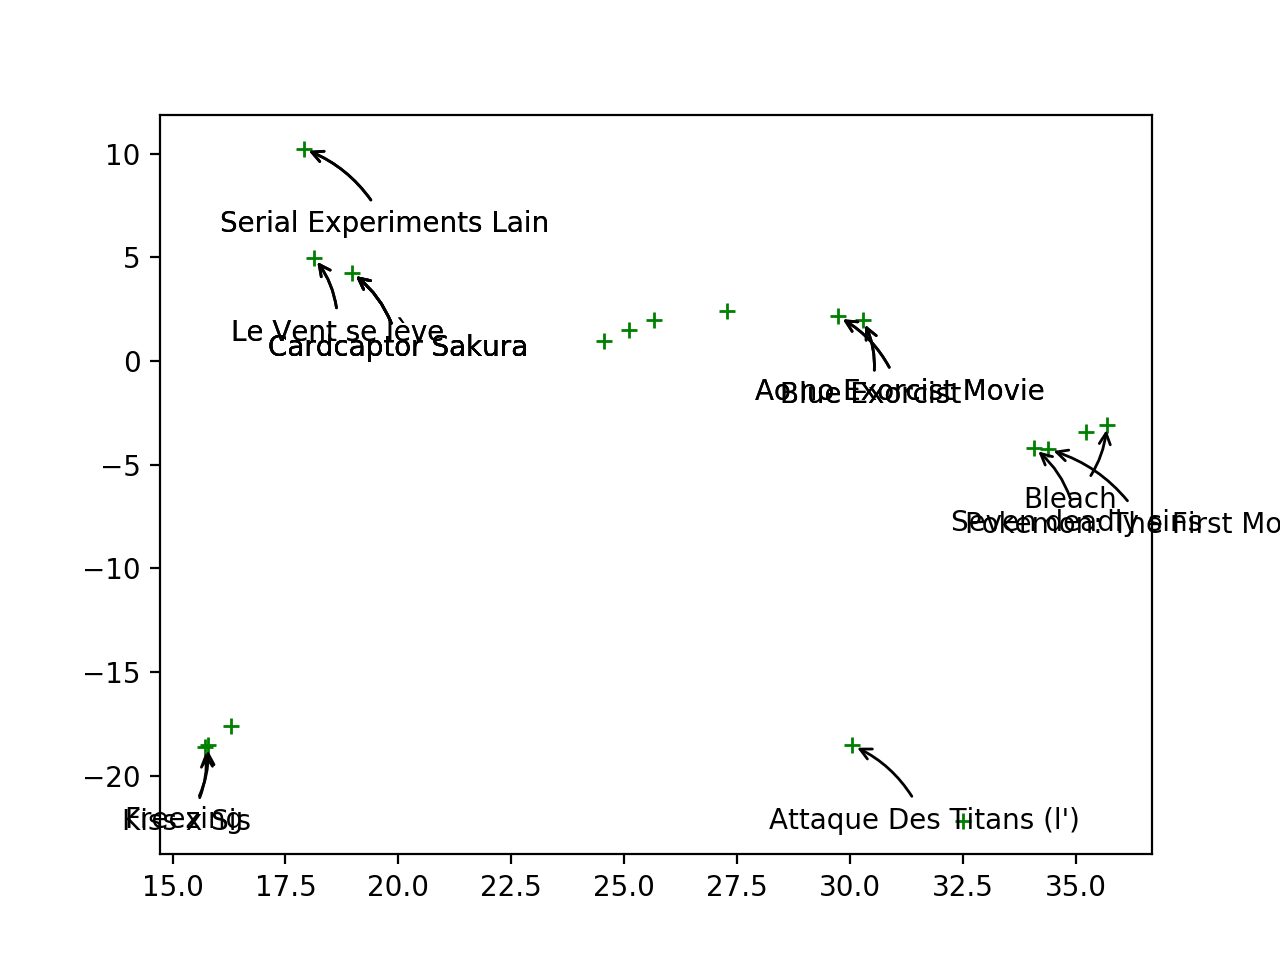

In [33]:
%matplotlib notebook

class MangakiViz:
    label = None
    def __init__(self, titles, coords, drawn, featured):
        fig = plt.figure()
        self.label = {}
        for work_id in drawn:
            p_id = dataset.encode_work[work_id]
            x, y = coords[p_id, 0], coords[p_id, 1]
            self.label[(x, y)] = titles[work_id]
            if p_id in featured:
                plt.plot(x, y, 'sb')  # Special points
                self.display(x, y)
            else:
                plt.plot(x, y, '+g', picker=5)
        # plt.plot(jjx, jjy, 'or')
        # plt.plot(predx, predy, 'og')
        fig.canvas.mpl_connect('pick_event', self.onpick)
    
    def display(self, x, y):
        plt.annotate(self.label[(x, y)], xy=(x, y), xycoords='data',
            xytext=(-30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2")
            )
    
    def where_am_i(self, point):
        plt.plot(point[0], point[1], 'or')
    
    def draw_history(self, history):
        plt.plot(history[:, 0], history[:, 1], 'og')
    
    def onpick(self, event):
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind
        points = tuple(zip(xdata[ind], ydata[ind]))
        x, y = points[0]
        self.display(x, y)

popular = list(Work.objects.popular()[:200].values_list('id', flat=True))
popular.remove(2)
drawn = list(set(popular) & set(dataset.decode_work[i] for i in range(1000)))
#titles = dataset.titles#works[:, 1].tolist()
sampled_items = []
viz = MangakiViz(titles, X_2d, drawn, sampled_items)
# viz.where_am_i((-0.61951029531106994, -0.15674103238147402))  # Old Ryan
#viz.where_am_i((clf.coef_[0][:2]))

In [73]:
get_closest(Work.objects.filter(title__icontains='Fullmetal')[0].id, 10)

Fullmetal Alchemist: The Conqueror of Shamballa
Fullmetal Alchemist: Premium OVA Collection
Fullmetal Alchemist: The Sacred Star of Milos
Fullmetal Alchemist: Reflections
Fullmetal Alchemist: Brotherhood OVA Collection
Fullmetal Alchemist
Fullmetal Alchemist: Brotherhood
L'Attaque des Titans
Le Royaume des chats
Brother, Dear Brother


In [74]:
get_closest(Work.objects.filter(title__endswith='Brotherhood')[0].id, 10)

Fullmetal Alchemist: Brotherhood
Fullmetal Alchemist
L'Attaque des Titans
Fullmetal Alchemist: Brotherhood OVA Collection
Fullmetal Alchemist: The Conqueror of Shamballa
Fullmetal Alchemist: Premium OVA Collection
Fullmetal Alchemist: The Sacred Star of Milos
Fullmetal Alchemist: Reflections
Le Royaume des chats
Ponyo sur la falaise


In [75]:
get_closest(1, 10)

Death Note
Code Geass: Hangyaku no Lelouch R2
Code Geass: Lelouch of the Rebellion Special Edition Black Rebellion
Code Geass: Lelouch of the Rebellion R2 Special Edition Zero Requiem
Code Geass: Hangyaku no Lelouch Recaps
Fate/Stay Night Unlimited Blade Works
Fate/stay night: Unlimited Blade Works (TV)
Fate/stay night: Unlimited Blade Works (TV) - Prologue
Parasyte -the maxim-
Fate/Zero 2nd Season


In [76]:
get_closest(Work.objects.filter(title__contains='Paprika')[0].id, 10)

Paprika
Tokyo Godfathers
Grave of the Fireflies
Perfect Blue
Porco Rosso
Millennium Actress
Paranoia Agent
Jin-Roh: The Wolf Brigade
Akira
Genius Party


In [77]:
get_closest(Work.objects.filter(title__contains='One Piece')[0].id, 10)

One Piece Film Z
Code Geass: Akito the Exiled 3 - The Brightness Falls
Space Dandy
Code Geass: Akito the Exiled 4
Code Geass: Akito the Exiled 2 - The Torn-Up Wyvern
Code Geass: Akito the Exiled 1 - The Wyvern Arrives
Gargantia on the Verdurous Planet
Disgaea
Pokemon: Mewtwo Returns
Kids on the Slope


In [78]:
get_closest(Work.objects.filter(title__contains='Tatami')[0].id, 10)

The Tatami Galaxy Specials
The Tatami Galaxy
GA: Geijutsuka Art Design Class
GA: Geijutsuka Art Design Class OVA
Sketchbook: Full Color's
Paniponi Dash!: Danjite Okonaeba Kishin mo Kore wo Saku
Pani Poni Dash!
Gakuen Utopia Manabi Straight! Special
Occult Academy Specials
X²: Double X


In [79]:
get_closest(Work.objects.filter(title__contains='Mind Game')[0].id, 10)

Mind Game
Neon Genesis Evangelion: The End of Evangelion
Genius Party Beyond
Planetes
Genius Party
Jin-Roh: The Wolf Brigade
Millennium Actress
Neon Genesis Evangelion
Evangelion: 1.0 You Are (Not) Alone
Evangelion: 3.0 You Can (Not) Redo


In [85]:
get_closest(Work.objects.filter(title='Neon Genesis Evangelion')[0].id, 10)

Neon Genesis Evangelion
Evangelion: 1.0 You Are (Not) Alone
Evangelion: 3.0 You Can (Not) Redo
Evangelion: 2.0 You Can (Not) Advance
Neon Genesis Evangelion: The End of Evangelion
Mind Game
Genius Party Beyond
Planetes
Genius Party
Panty and Stocking with Garterbelt


In [89]:
get_closest(Work.objects.filter(title__icontains='Puella Magi')[1].id, 10)

Puella Magi Madoka Magica the Movie Part III: Rebellion
Puella Magi Madoka Magica the Movie Part I: Beginnings
Puella Magi Madoka Magica the Movie Part II: Eternal
Mahou Shoujo Madoka★Magica
Bakemonogatari
Nisemonogatari
Tsukimonogatari
Monogatari Series: Second Season
Hanamonogatari
Nekomonogatari Black: Tsubasa Family


In [92]:
get_closest(Work.objects.filter(title__endswith='Madoka★Magica')[0].id, 20)

Mahou Shoujo Madoka★Magica
Puella Magi Madoka Magica the Movie Part I: Beginnings
Puella Magi Madoka Magica the Movie Part II: Eternal
Puella Magi Madoka Magica the Movie Part III: Rebellion
Bakemonogatari
Nisemonogatari
Tsukimonogatari
Monogatari Series: Second Season
Hanamonogatari
Nekomonogatari Black: Tsubasa Family
K-On!!: Keikaku!
K-On!: Live House!
Suzumiya Haruhi no Yuuutsu (2009)
K-ON! The Movie
Suzumiya Haruhi no Shoushitsu
Suzumiya Haruhi no Yuuutsu
Shirobako
K-On!!
K-On!
My Ordinary Life


In [94]:
get_closest(Work.objects.filter(title__contains='Resonance')[0].id, 15)

Terror in Resonance
Rokka: Braves of the Six Flowers
God Eater
God Eater
K: Missing Kings
Subete ga F ni Naru: The Perfect Insider
Kono Subarashii Sekai ni Shukufuku wo!
Utawarerumono: Itsuwari no Kamen
K
D.Gray-man
Horizon in the Middle of Nowhere
Coppelion
Letter Bee Reverse
Kiznaiver
ERASED


In [101]:
get_closest(Work.objects.filter(title__contains='Suzumiya')[5].id, 15)

Suzumiya Haruhi no Yuuutsu
Suzumiya Haruhi no Shoushitsu
Suzumiya Haruhi no Yuuutsu (2009)
Steins;Gate
Steins;Gate: Egoistic Poriomania
Steins;Gate: Fuka Ryouiki no Déjà vu
Cencoroll
Fumiko's Confession
La Maison en Petits Cubes
Nodame Cantabile
Bodacious Space Pirates the Movie: Abyss of Hyperspace
Nodame Cantabile Paris Hen
Nodame Cantabile Finale
Mahou Shoujo Madoka★Magica
Shirobako


In [102]:
get_closest(Work.objects.filter(title__contains='Suzumiya')[1].id, 15)

The Disappearance of Haruhi Suzumiya
Trefle
New York New York
Barakamon: Mijikamon
Bungou Stray Dogs 2nd Season
Macross Zero
On Your Mark
Bungou Stray Dogs 2nd Season
Bungou Stray Dogs 2nd Season
Memories
Space Patrol Luluco
The Anthem of the Heart -Beautiful Word, Beautiful World-
Viewfinder
FLCL
Hori-san to Miyamura-kun


In [110]:
Work.objects.filter(title__startswith='Bungou Stray').values_list('id', 'rating')

<WorkQuerySet [(15211, 335232), (15211, 346378), (14438, 304941), (14438, 323505), (15210, 335231), (15210, 347715), (15212, 347716), (15213, None), (14437, 304940), (14437, 321318), (14437, 335230), (14437, 343622)]>

In [112]:
for rating in Rating.objects.filter(work__title__startswith='Bungou Stray'):
    print(rating, rating.work_id)

Soubi favorite Bungou Stray Dogs 2nd Season 15211
Dreamy willsee Bungou Stray Dogs 2nd Season 15211
dorito willsee Bungou Stray Dogs OVA 14438
Heliard willsee Bungou Stray Dogs OVA 14438
Soubi favorite Bungou Stray Dogs 2nd Season 15210
flyeram neutral Bungou Stray Dogs 2nd Season 15210
flyeram like Bungou Stray Dogs OVA 15212
dorito willsee Bungou Stray Dogs 2nd Season 14437
Pearl willsee Bungou Stray Dogs 2nd Season 14437
Soubi favorite Bungou Stray Dogs 2nd Season 14437
Shirakane like Bungou Stray Dogs 2nd Season 14437


In [114]:
get_closest(Work.objects.filter(title__contains='Parasyte')[0].id, 15)

Parasyte -the maxim-
Death Billiards
Death Parade
Brave Story
Psycho-Pass: The Movie
Psycho-Pass 2
Death Note
Code Geass: Hangyaku no Lelouch R2
GARO THE ANIMATION
Psycho-Pass
Code Geass: Lelouch of the Rebellion Special Edition Black Rebellion
THE IDOLM@STER MOVIE: BEYOND THE BRILLIANT FUTURE!
Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season
Code Geass: Lelouch of the Rebellion R2 Special Edition Zero Requiem
Soukyuu no Fafner: Dead Aggressor - Exodus


In [117]:
get_closest(Work.objects.filter(title__contains='Lie in April')[0].id, 15)

Your Lie in April
One Week Friends
The Garden of Words
Steins;Gate: Fuka Ryouiki no Déjà vu
Steins;Gate: Egoistic Poriomania
Steins;Gate
Grave of the Fireflies
Eden of The East the Movie I: The King of Eden
Higashi no Eden
Eden of The East the Movie II: Paradise Lost
La Maison en Petits Cubes
Spirited Away
Fumiko's Confession
Cencoroll
Shinsekai yori


In [120]:
get_closest(Work.objects.filter(title__contains='Higashi no Eden')[0].id, 15)

Higashi no Eden
Eden of The East the Movie I: The King of Eden
Eden of The East the Movie II: Paradise Lost
Steins;Gate: Fuka Ryouiki no Déjà vu
Steins;Gate
Steins;Gate: Egoistic Poriomania
Baccano!
Your Lie in April
Baccano! Specials
Full Metal Panic!
Full Metal Panic? Fumoffu
One Week Friends
Full Metal Panic! The Second Raid
Full Metal Panic! The Second Raid: Wari to Hima na Sentaichou no Ichinichi
Nodame Cantabile


In [121]:
get_closest(Work.objects.filter(title__contains='Spirited')[0].id, 15)

Spirited Away
Grave of the Fireflies
The Garden of Words
One Week Friends
Mushishi
Shinsekai yori
Your Lie in April
Mushishi Zoku Shou 2nd Season
Mushishi Zoku Shou Special
MUSHI-SHI -Next Passage-
Mushishi Special: Hihamukage
R.O.D OVA
Haré+Guu
Haré+Guu Deluxe
Mobile Police Patlabor Minimum


In [122]:
get_closest(Work.objects.filter(title__contains='Clannad')[0].id, 15)

Clannad
Clannad: After Story
Clannad After Story: Another World, Kyou Chapter
Clannad: Another World, Tomoyo Chapter
School Rumble
Angel Beats!
School Rumble 2nd Term
Angel Beats!: Another Epilogue
School Rumble Third Term
School Rumble Ichi Gakki Hoshuu
Hayate the Combat Butler!!
Hayate the Combat Butler
Girls & Panzer OVAs
Girls & Panzer
Girls und Panzer: Kore ga Hontou no Anzio-sen Desu!


In [125]:
get_closest(Work.objects.filter(title__contains='No Game')[2].id, 15)

No Game No Life
Noragami
Black Bullet
Guilty Crown
Sword Art Online II
Sword Art Online
K
Magi: The Labyrinth of Magic
Magi: The Kingdom of Magic
K: Missing Kings
Kono Subarashii Sekai ni Shukufuku wo!
God Eater
God Eater
Magi: Sinbad no Bouken
The Seven Deadly Sins


In [127]:
get_closest(Work.objects.filter(title__contains='Kaiba')[0].id, 15)

Kaiba
Kemonozume
Samurai Deeper Kyo
Gankutsuou: The Count of Monte Cristo
His and Her Circumstances
.hack//Sign
Vandread: The Second Stage
Kiddy Grade
RahXephon Interlude: Her and Herself/Thatness and Thereness
Samurai Champloo
Trinity Blood
Useless Witch Doremi Kaboom!
Fruits Basket
Oh! My Goddess
RahXephon


In [132]:
get_closest(Work.objects.filter(title__contains='.hack//')[1].id, 15)

.hack//Quantum Specials
.hack//Legend of the Twilight Offline Meeting Special
.hack//Versus: The Thanatos Report
.hack//G.U. Trilogy: Parody Mode
.hack//G.U. Returner
.hack//G.U. Trilogy
Gundam: Mission To The Rise
Digimon Adventure tri. 1: Saikai
Ghost in the Shell: Stand Alone Complex: Tachikomatic Days Fan Disc
Ikkitousen: Xtreme Xecutor Specials
Initial D: Project D to the Next Stage - Project D e Mukete
Persona 3 the Movie: #2 Midsummer Knight's Dream
Persona 3 the Movie: #1 Spring of Birth
Romeo and the Black Brothers
Hakuouki Reimeiroku Tokuten Disc


In [138]:
get_closest(Work.objects.filter(title__contains='Lion')[2].id, 15)

Jojo's bizarre adventure - Saison 8 - Jojo Lion
Jojo's bizarre adventure - Saison 7 - Steel Ball Run
Jojo's bizarre adventure - Saison 6 - Stone Ocean
Jojo's bizarre adventure
Jojo's bizarre adventure - Saison 5 - Golden Wind
Jojo's bizarre adventure - Saison 2 - Battle Tendency
Jojo's bizarre adventure - Saison 3 - Stardust Crusaders
Jojo's bizarre adventure - Saison 1 - Phantom Blood
Honey and Clover
Gokinjo, une vie de quartier
Happy science
Parmi eux - Hanakimi
Tokyo Babylon
X - 1999
Ayashi no ceres


In [141]:
get_closest(Work.objects.filter(title__contains='Psycho 100')[0].id, 15)

Mob Psycho 100
Sound! Euphonium 2
Sound! Euphonium Episode 14 – Ready, Set, Monaka
Sound! Euphonium
WWW.WAGNARIA!!
Gabriel DropOut
Re:CREATORS
Tantei Opera Milky Holmes
Mr. Osomatsu
Rage of Bahamut: Virgin Soul
Granblue Fantasy The Animation
Zero kara Hajimeru Mahou no Sho
The Mystic Archives of Dantalian: Ibarahime
Hell Girl: Two Mirrors
Hell Girl: Three Vessels


In [142]:
get_closest(Work.objects.filter(title__contains='Re:Zero')[0].id, 15)

Re:Zero kara Hajimeru Isekai Seikatsu
Noragami OVA 2
Non Non Biyori Repeat
Rokka no Yuusha Picture Drama
Ichigo Mashimaro Episode 0
Hanayamata
Tantei Opera Milky Holmes
Glasslip
Toradora!: Bentou no Gokui
Natsume's Book of Friends Season 4
Toradora!
Koe no Katachi
THE IDOLM@STER CINDERELLA GIRLS 2nd ANNIVERSARY PV
Little Witch Academia (TV)
Hungry Zombie Francesca


In [148]:
get_closest(Work.objects.filter(title__contains='Card Captor Sakura')[0].id, 15)

Card Captor Sakura Movie 2: The Sealed Card
Cardcaptor Sakura: The Movie
Card Captor Sakura
Cardcaptor Sakura Specials
Cardcaptor Sakura: Leave It to Kero-chan
Bakuman. 3
Bakuman. 2
Bakuman.
Evangelion - Neon genesis
Dna²
Final Fantasy: The Spirits Within
Black Lagoon: Roberta's Blood Trail
Genmukan: The Sin of Desire & Shame
Please Save My Earth Movie: From Alice to Rin-kun
Fault!!


In [149]:
get_closest(Work.objects.filter(title__contains='Zetman')[0].id, 15)

Zetman
Gokudo
New Fist of the North Star
009-1
The Big O
Revolutionary Girl Utena: The Adolescence of Utena
Lupin III: Part II
Revolutionary Girl Utena
Bludgeoning Angel Dokuro-chan
Fist of the North Star: Legend of Kenshiro
Revolutionary Girl Utena: The Adolescence of Utena
Fist of the North Star 2
Blue Gender
Ghost Talker's Daydream
Karakuri Zoushi Ayatsuri Sakon


In [151]:
get_closest(Work.objects.filter(title__contains='Utena')[1].id, 15)

Revolutionary Girl Utena
Kite
Those Who Hunt Elves
Bludgeoning Angel Dokuro-chan
Blood+
Blue Gender
Revolutionary Girl Utena: The Adolescence of Utena
Those Who Hunt Elves II
The Big O
Millennium Actress
009-1
Revolutionary Girl Utena: The Adolescence of Utena
Those Who Hunt Elves
Those Who Hunt Elves II
Ichi The Killer: Episode 0


In [153]:
get_closest(Work.objects.filter(title__contains='Millennium Actress')[1].id, 15)

Millennium Actress
Macross Frontier: The False Songstress
Those Who Hunt Elves II
Mobile Suit Gundam - The origin
Revolutionary Girl Utena: The Adolescence of Utena
Those Who Hunt Elves
Samurai 7
Golgo 13
Sanctuary
Those Who Hunt Elves II
New Fist of the North Star
Those Who Hunt Elves
Ichi The Killer: Episode 0
Ghost Talker's Daydream
Endless Orbit SSX
